In [2]:
import numpy as np
import pandas as pd
import igraph as ig
import dowhy as dw
import matplotlib.pyplot as plt
import automates.model_analysis.identification_algorithms as ia

# DoWhy Confounding Example

## Objectives
There are two goals:
1. Illustrate that estimating an unidentifiable effect leads to inaccurate estimation
2. Illustrate that ignoring known confounding rather than correcting for it leads to incorrect decisions

I will construct examples that highlight why, under certain conditions, ignoring information about identifiability gained from graph structure can lead to incorrect conclusions.

## Example 1: The Bow-Arc Graph
The bow-arc graph is the smallest unidentifiable graph (Shiptser and Pearl, page 1949), so let us examine this model first.

Suppose a dice is rolled whose outcome $U$ is not observed. A second dice is rolled and the outcome of this roll, plus the first is observed.  The outcome $y_i = 6u_i + 0.75d_i + \mathcal{N}(2, 1)$.

The Structural Causal Model (SCM) has the following structural equations:

\begin{align*} 
U &= f_U(\varepsilon_U) \\
D &= f_D(U, \varepsilon_D) \\
Y &= f_Y(U, D, \varepsilon_Y), \text{ where } \varepsilon_U \perp \varepsilon_D \perp \varepsilon_Y
\end{align*}

The graph corresponding to the scenario:

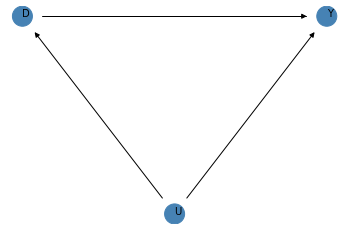

In [3]:
# Specify iGraph
g1 = ig.Graph(edges=[[0, 1], [2, 1], [2, 0]], directed=True)
g1.vs["name"] = ["D", "Y", "U"]; g1.vs["description"] = ["O", "O", "U"]
g1.es["description"] = ["O", "U", "U"]

# plot graph
v_style1 = {"vertex_label": g1.vs["name"], "vertex_size": 20, "layout": g1.layout("rt", mode="all", root=[2])}
fig, ax = plt.subplots(); plt.axis('off')
ig.plot(g1, target=ax, **v_style1)

### Simulation
I sample from the following error distributions:
\begin{align*}
\varepsilon_U &\sim \text{Uniform}(1, 6) \\
\varepsilon_D &\sim \text{Uniform}(1, 6) \\
\varepsilon_Y &\sim \mathcal{N}(2, 1) \\
\end{align*}

Then construct the observations and outcome using the following structural equations for the graph and our known relationship:
\begin{align*}
u_i &= \varepsilon_{u_i} \\
d_i &= u_i + \varepsilon_{d_i} \\
y_i &= 6*u_i + 1*d_i+\varepsilon_{y_i} \\
\end{align*}

This is repeated 100 times:

In [4]:
# Sample n times from Error Distributions
n = 100; np.random.seed(2021)
epsilon_U = np.random.randint(1, 7, n); U = epsilon_U
epsilon_D = np.random.randint(1, 7, n); D = epsilon_D+epsilon_U
epsilon_Y = np.random.normal(2, 1, n); Y = 6*epsilon_U + 0.75*epsilon_D + epsilon_Y


# Construct Observations and Outcomes
sim_data = pd.DataFrame(np.transpose(np.array([D, Y])), columns = ["D", "Y"])
sim_data[0:10]

,D,Y
0,6.0,34.524322
1,11.0,40.772993
2,8.0,20.517844
3,3.0,9.586113
4,10.0,40.323303
5,10.0,36.031992
6,5.0,26.917193
7,10.0,41.401670
8,8.0,39.638478
9,10.0,40.638358


### Identification, ID-Algorithm
Suppose we implement *reference* ID-Algorithm.

In [5]:
# Implement ID Algorithm on the Graph
results = ia.identifiability(["Y"], ["D"], g1)

IDANotIdentifiable: Not Identifiable

We see that the effect $P(Y|do(d))$ is not identifiable by the ID-Algorithm.

### Identification, DoWhy
Now, using DoWhy, I input the graph and data (DoWhy requires that data be bundled with the graph) and then run DoWhy's identification step.

In [7]:
# Specify DoWhy model
dw_graph = 'digraph {U [observed="no"]; D [observed="yes"]; Y [observed="yes"]; U -> Y; U -> D; D -> Y}'
dw_model = dw.CausalModel(data=sim_data, treatment=["D"], outcome=["Y"], graph=dw_graph)

# Implement DoWhy identification
dw_id = dw_model.identify_effect(estimand_type="nonparametric-ate", method_name="default", proceed_when_unidentifiable=True)
print(dw_id)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                  
────(Expectation(Y))
d[D]                
Estimand assumption 1, Unconfoundedness: If U→{D} and U→Y then P(Y|D,,U) = P(Y|D,)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



We see that DoWhy warns us about the assumptions it's making, but proceeds anyway. It returns a regression coefficient as the "identified" value.

### Estimation, DoWhy
If we ignore DoWhy's warning and proceed with estimation (using linear regression) anyway, we get the following

In [8]:
# Implement DoWhy linear estimation method
dw_estimate = dw_model.estimate_effect(dw_id, method_name="backdoor.linear_regression",test_significance=True)
print(dw_estimate)

# return output of interest

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                  
────(Expectation(Y))
d[D]                
Estimand assumption 1, Unconfoundedness: If U→{D} and U→Y then P(Y|D,,U) = P(Y|D,)

## Realized estimand
b: Y~D
Target units: ate

## Estimate
Mean value: 3.4096408896276573
p-value: [1.39798417e-21]



From the equations we used to simulate the data, we know that the true ATE should be 1, which is quite far from what we estimate.

Below is an example of what we could estimate given the values of U as well.

In [9]:
sim_true = pd.DataFrame(np.transpose(np.array([U, D, Y])), columns = ["U", "D", "Y"])
true_graph = 'digraph {U; D; Y; U -> Y; U -> D; D -> Y}'
true_model = dw.CausalModel(data=sim_true, treatment=["D"], outcome=["Y"], graph=true_graph)
true_id = true_model.identify_effect(estimand_type="nonparametric-ate", method_name="default", proceed_when_unidentifiable=True)
true_estimate = true_model.estimate_effect(true_id, method_name="backdoor.linear_regression",test_significance=True)
print(true_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                    
────(Expectation(Y|U))
d[D]                  
Estimand assumption 1, Unconfoundedness: If U→{D} and U→Y then P(Y|D,U,U) = P(Y|D,U)

## Realized estimand
b: Y~D+U
Target units: ate

## Estimate
Mean value: 0.806781120600693
p-value: [1.84613141e-22]

